In [2]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

In [3]:
# Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

In [4]:
# Preprocessing
# Drop irrelevant columns
data = data.drop(columns=['Wiki Page', 'Title', 'Director', 'Cast'])


In [5]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])
data['Genre'] = label_encoder.fit_transform(data['Genre'])


In [6]:
# Convert 'Plot' text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100)
plot_tfidf = tfidf_vectorizer.fit_transform(data['Plot'].fillna(''))

In [7]:
# Combine numeric and textual features
numeric_features = data[['Release Year', 'Origin/Ethnicity', 'Genre']].values
numeric_features = StandardScaler().fit_transform(numeric_features)
numeric_features_sparse = csr_matrix(numeric_features)


In [8]:
# Combine numeric features and TF-IDF features
combined_features_sparse = csr_matrix(
    np.hstack((numeric_features_sparse.toarray(), plot_tfidf.toarray()))
)

In [9]:
# Apply RandomOverSampler to balance the data
oversampler = RandomOverSampler(random_state=42)
combined_features_oversampled, labels_oversampled = oversampler.fit_resample(
    combined_features_sparse.toarray(), data['Genre']
)

In [17]:
# Apply Birch Clustering
birch_model = Birch(n_clusters=7, threshold=0.3, branching_factor=50)
birch_model.fit(combined_features_oversampled)

# Get cluster labels for the oversampled data
oversampled_cluster_labels = birch_model.labels_


In [23]:
# Function to map cluster labels to true labels
def map_labels(true_labels, cluster_labels):
    # Create the contingency matrix
    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    
    # Perform the Hungarian algorithm to find the best mapping
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.values)  # Maximizing the contingency matrix values
    
    # Create a mapping dictionary
    mapping = {col: row_ind[i] for i, col in enumerate(col_ind)}
    
    # Map cluster labels to true labels, return -1 for unmapped labels
    return [mapping.get(label, -1) for label in cluster_labels]

# Map cluster labels to match true labels
mapped_labels = map_labels(labels_oversampled, birch_model.labels_)

# Filter out unmapped labels
valid_indices = [i for i, label in enumerate(mapped_labels) if label != -1]
filtered_true_labels = np.array(labels_oversampled)[valid_indices]
filtered_mapped_labels = np.array(mapped_labels)[valid_indices]

# Calculate cluster accuracy
cluster_accuracy = accuracy_score(filtered_true_labels, filtered_mapped_labels)
print(f"Cluster Accuracy: {cluster_accuracy}")

from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(combined_features_oversampled, birch_model.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(filtered_true_labels, filtered_mapped_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

# Calculate Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(filtered_true_labels, filtered_mapped_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score}")



Cluster Accuracy: 0.5377798507462687
Silhouette Score: 0.29337116844629035
Adjusted Rand Index (ARI): 0.3690622089570313
Normalized Mutual Information (NMI): 0.5357080930337832


In [12]:
# Reduce features to 2D for visualization using PCA
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(combined_features_sparse.toarray())

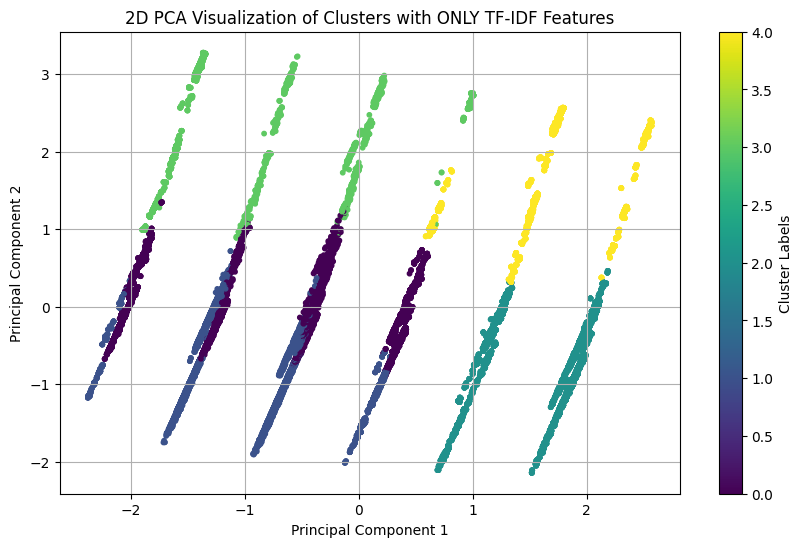

In [16]:
# Perform PCA on the oversampled data to reduce features to 2D for visualization
pca_2d_oversampled = PCA(n_components=2)
reduced_2d_oversampled = pca_2d_oversampled.fit_transform(combined_features_oversampled)

# Add cluster labels to the oversampled data DataFrame
oversampled_data = pd.DataFrame(combined_features_oversampled)
oversampled_data['cluster'] = birch_model.labels_

# 2D scatter plot of clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_2d_oversampled[:, 0], reduced_2d_oversampled[:, 1], c=oversampled_data['cluster'], cmap='viridis', s=10)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("2D PCA Visualization of Clusters with ONLY TF-IDF Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()